# Development of Model
## Analysis

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Dummy-Data.csv')
df

,AppID,Ins_Age,Ins_Gender,Ht,Wt,IssueDate
0,56372,31,Male,510,185,NaN
1,34565,35,Male,510,205,NaN
2,57732,45,Female,510,125,NaN
3,87324,38,Male,503,175,NaN
4,12323,39,Female,600,252,NaN
...,...,...,...,...,...,...
95,99511,35,Male,510,275,NaN
96,23781,27,Male,604,145,NaN
97,99517,35,Female,507,190,NaN
98,99520,38,Female,510,144,NaN


In [3]:
df.describe()

,AppID,Ins_Age,Ht,Wt,IssueDate
count,100.000000,100.000000,100.000000,100.00000,0.0
mean,79455.570000,37.320000,527.720000,165.15000,NaN
std,31123.726942,12.103827,39.482787,27.66224,NaN
min,12123.000000,19.000000,500.000000,110.00000,NaN
25%,64296.000000,27.750000,506.000000,145.00000,NaN
50%,99444.500000,36.000000,509.000000,170.00000,NaN
75%,99917.000000,47.000000,511.000000,180.00000,NaN
max,100345.000000,59.000000,605.000000,275.00000,NaN


**Based on data above and business rules from documentation**: 

- IssueData is alway null and also not useful at all.

## Create a Training Data Set

In [4]:
 def bmi(wt,ht):
    ht_m=(((ht//100)*12+ht%100)*0.0254)
    wt_kg=wt/2.20462
    bmi=wt_kg/(ht_m**2)
    return bmi

In [5]:
def age_group(age):
    if age < 18:
        return 0
    elif age < 40:
        return 1
    elif age <= 60:
        return 2
    else:
        return 3

In [6]:
df['bmi'] = df.apply(lambda x: bmi(x.Wt, x.Ht), axis=1)
df['age_group'] = df.apply(lambda x: age_group(x.Ins_Age), axis=1)

df.drop(columns=['IssueDate','Ins_Age','Ht','Wt'],inplace=True)

In [7]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
enc.fit(df[['Ins_Gender']])

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


OrdinalEncoder()

In [8]:
enc.categories_

[array(['Female', 'Male'], dtype=object)]

In [9]:
df[['Ins_Gender']]=enc.transform(df[['Ins_Gender']])

In [10]:
def quote_value(gender,bmi,age_group):
        if (bmi > 17.49 and bmi < 38.5):
            base_value = 500
        else:
            if age_group == 0:
                base_value = 500
            elif age_group == 1:
                base_value = 750
            elif age_group == 2:
                base_value = 1000
            else:
                base_value = 2000
        if gender == 0:
            return base_value * 0.9
        else:
            return base_value

In [11]:
df['quote'] = df.apply(lambda x: quote_value(x.Ins_Gender,x.bmi,x.age_group), axis=1)

In [12]:
df.head()

,AppID,Ins_Gender,bmi,age_group,quote
0,56372,1.0,26.544495,1,500.0
1,34565,1.0,29.414170,1,500.0
2,57732,0.0,17.935470,2,450.0
3,87324,1.0,30.999577,1,500.0
4,12323,0.0,34.177034,1,450.0


In [13]:
X=df[['Ins_Gender','bmi','age_group']].to_numpy()

In [14]:
Y=df[['quote']].to_numpy()

## Split to train and test set

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['Ins_Gender','bmi','age_group']].to_numpy(),
                                     df[['quote']].to_numpy(),
                                     shuffle=True,
                                     test_size=0.1,
                                     random_state=0)

In [16]:
print(len(X_train), len(X_test))

90 10


## Train a Model

In [18]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=10)
clf=clf.fit(X_train,y_train.ravel())

In [19]:
print('Train Score',clf.score(X_train,y_train))
print('Test Score',clf.score(X_test,y_test))

Train Score 1.0
Test Score 0.8


In [20]:
clf.predict(X_test)

array([450., 500., 450., 500., 500., 450., 500., 500., 500., 500.])

In [21]:
y_test

array([[500.],
       [500.],
       [450.],
       [500.],
       [500.],
       [450.],
       [500.],
       [500.],
       [500.],
       [750.]])

## Visualize a random tree

In [22]:
from sklearn.tree import export_graphviz, plot_tree

export_graphviz(clf.estimators_[0],out_file='tree.dot')


[Text(342.40909090909093, 713.475, 'X[0] <= 0.5\ngini = 0.527\nsamples = 59\nvalue = [28, 55, 0, 3, 3, 1]'),
 Text(152.1818181818182, 509.625, 'X[1] <= 17.738\ngini = 0.175\nsamples = 22\nvalue = [28, 0, 0, 0, 3, 0]'),
 Text(76.0909090909091, 305.775, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 0, 0, 3, 0]'),
 Text(228.27272727272728, 305.775, 'gini = 0.0\nsamples = 20\nvalue = [28, 0, 0, 0, 0, 0]'),
 Text(532.6363636363636, 509.625, 'X[2] <= 1.5\ngini = 0.128\nsamples = 37\nvalue = [0, 55, 0, 3, 0, 1]'),
 Text(380.4545454545455, 305.775, 'X[1] <= 17.019\ngini = 0.165\nsamples = 23\nvalue = [0, 30, 0, 3, 0, 0]'),
 Text(304.3636363636364, 101.92499999999995, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 0, 3, 0, 0]'),
 Text(456.54545454545456, 101.92499999999995, 'gini = 0.0\nsamples = 21\nvalue = [0, 30, 0, 0, 0, 0]'),
 Text(684.8181818181819, 305.775, 'X[1] <= 19.913\ngini = 0.074\nsamples = 14\nvalue = [0, 25, 0, 0, 0, 1]'),
 Text(608.7272727272727, 101.92499999999995, 'gini = 0.0\nsamples =

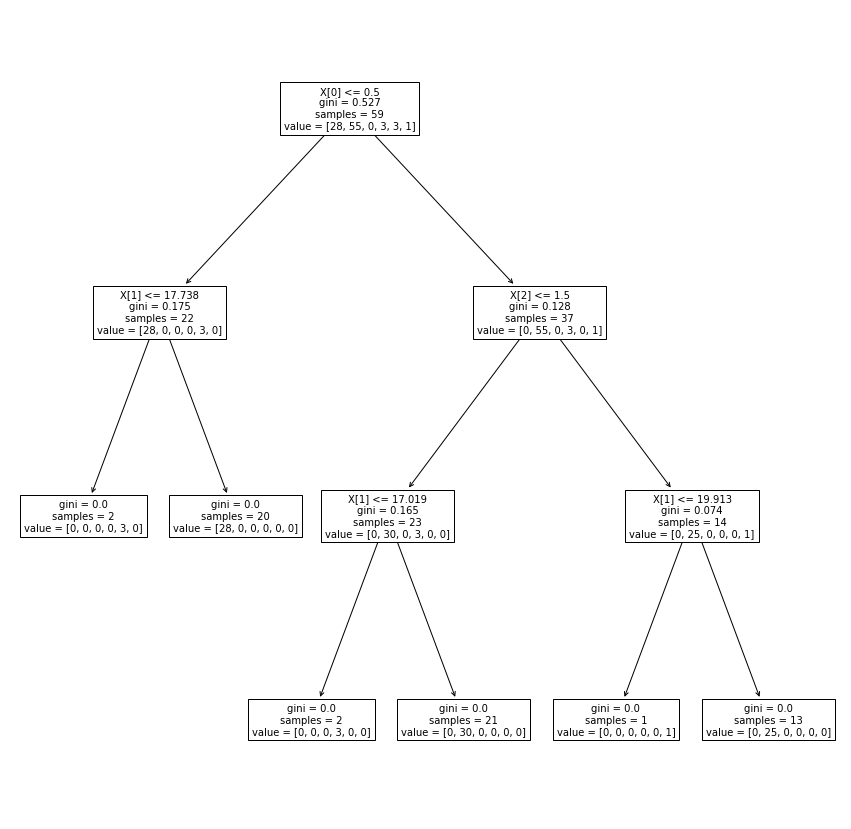

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,15))

plot_tree(clf.estimators_[0], fontsize=10)

## Save the model

In [33]:
import os
os.getcwd()

'/Users/sreekanthpalagiri/Learning/Pramerica'

In [34]:
from joblib import dump

dump(clf, './src/model/filename.joblib') 

['./src/model/filename.joblib']

# Creating An application for inference

## Create a Transformation Class and testing it

In [24]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OrdinalEncoder


In [68]:
class TransformData(TransformerMixin):
        
    def bmi(self,wt,ht):
        ht_m=(((ht//100)*12+ht%100)*0.0254)
        wt_kg=wt/2.20462
        bmi=wt_kg/(ht_m**2)
        return bmi
    
    def age_group(self,age):
        if age < 18:
            return 0
        elif age < 40:
            return 1
        elif age <= 60:
            return 2
        else:
            return 3
        
    def quote_value(gender,bmi,age_group):
        if (bmi > 17.49 and bmi < 38.5):
            base_value = 500
        else:
            if age_group == 0:
                base_value = 500
            elif age_group == 1:
                base_value = 750
            elif age_group == 2:
                base_value = 1000
            else:
                base_value = 2000
        if gender == 0:
            return base_value * 0.9
        else:
            return base_value
        
    def encode(self):
        enc = OrdinalEncoder()
        enc.fit(df[['Ins_Gender']])
        self.X[['Ins_Gender']]=enc.transform(self.X[['Ins_Gender']])
        
            
    def transform(self, X):
        self.X=X
        self.X['bmi'] = self.X.apply(lambda x: self.bmi(x.Wt, x.Ht), axis=1)
        self.X['age_group'] = self.X.apply(lambda x: self.age_group(x.Ins_Age), axis=1)
        
        self.X.drop(columns=['Ht','Wt','IssueDate','Ins_Age'],inplace=True)
        
        self.encode()
        
        return self.X
    

In [69]:
df = pd.read_csv('Dummy-Data.csv')

td=TransformData()
td.transform(df)

,AppID,Ins_Gender,bmi,age_group
0,56372,1.0,26.544495,1
1,34565,1.0,29.414170,1
2,57732,0.0,17.935470,2
3,87324,1.0,30.999577,1
4,12323,0.0,34.177034,1
...,...,...,...,...
95,99511,1.0,39.458034,1
96,23781,1.0,17.649794,1
97,99517,0.0,29.757937,1
98,99520,0.0,20.661661,1


## Create a Model Class from trained Model

In [79]:
from sklearn.base import ClassifierMixin
from joblib import load

class InsuranceModel(ClassifierMixin):
    def __init__(self):
        self.clf = load('./src/model/filename.joblib') 
        
    def fit (self,X):
        pass
                
    def predict(self,X):
        self.X =X
        self.X['quote'] = clf.predict(self.X[['Ins_Gender','bmi','age_group']].to_numpy())
        return df

## Create and testing Pipeline

In [59]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('transformer', TransformData()), ('InsuranceModel', InsuranceModel())])

In [60]:
df = pd.read_csv('Dummy-Data.csv')
pipe.predict(df)

,AppID,Ins_Gender,bmi,age_group,quote
0,56372,1.0,26.544495,1,500.0
1,34565,1.0,29.414170,1,500.0
2,57732,0.0,17.935470,2,450.0
3,87324,1.0,30.999577,1,500.0
4,12323,0.0,34.177034,1,450.0
...,...,...,...,...,...
95,99511,1.0,39.458034,1,500.0
96,23781,1.0,17.649794,1,500.0
97,99517,0.0,29.757937,1,450.0
98,99520,0.0,20.661661,1,450.0


## Putting it all together in a flask ap

**Model Module(model.py file to be imported in app.py)**

In [85]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import ClassifierMixin
from joblib import load
from sklearn.pipeline import Pipeline


class TransformData(TransformerMixin):
        
    def bmi(self,wt,ht):
        ht_m=(((ht//100)*12+ht%100)*0.0254)
        wt_kg=wt/2.20462
        bmi=wt_kg/(ht_m**2)
        return bmi
    
    def age_group(self,age):
        if age < 18:
            return 0
        elif age < 40:
            return 1
        elif age <= 60:
            return 2
        else:
            return 3
        
    def quote_value(gender,bmi,age_group):
        if (bmi > 17.49 and bmi < 38.5):
            base_value = 500
        else:
            if age_group == 0:
                base_value = 500
            elif age_group == 1:
                base_value = 750
            elif age_group == 2:
                base_value = 1000
            else:
                base_value = 2000
        if gender == 0:
            return base_value * 0.9
        else:
            return base_value
        
    def encode(self):
        enc = OrdinalEncoder()
        enc.fit( self.X[['Ins_Gender']])
        self.X[['Ins_Gender']]=enc.transform(self.X[['Ins_Gender']])
        
            
    def transform(self, X):
        self.X=X
        self.X['bmi'] = self.X.apply(lambda x: self.bmi(x.Wt, x.Ht), axis=1)
        self.X['age_group'] = self.X.apply(lambda x: self.age_group(x.Ins_Age), axis=1)
        
        self.X.drop(columns=['Ht','Wt','IssueDate','Ins_Age'],inplace=True)
        
        self.encode()
        
        return self.X
    

class InsuranceModel(ClassifierMixin):
    def __init__(self):
        self.clf = load('./src/model/filename.joblib') 
        
    def fit (self,X):
        pass
                
    def predict(self,X):
        self.X= X
        self.X['quote'] = self.clf.predict(X[['Ins_Gender','bmi','age_group']].to_numpy())
        return self.X[['AppID','quote']]
    
pipe = Pipeline([('transformer', TransformData()), ('InsuranceModel', InsuranceModel())])

**Flask- app.py**

In [89]:
from flask import Flask, request, jsonify
import pandas as pd
##import pipeline here

app = Flask(__name__)

@app.route('/',methods=['GET'])
def index():
    content = request.json
    df = pd.DataFrame.from_dict(content)
    pred=pipe.predict(df)
    return jsonify(pred.values.tolist())


if __name__=='__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [05/Jul/2022 22:43:11] "GET / HTTP/1.1" 200 -


## Deployment Steps

### Created requirements.txt as below and put it in the source folder

In [ ]:
flask
pandas
scikit-learn

### Created a build.yaml file to build you docker image as below

In [ ]:
FROM python:3.11.0b3-bullseye


USER 0

# setup working directory for jenkins_api
RUN mkdir /insmodel
WORKDIR /insmodel/
ADD src /insmodel/
RUN chmod 777 -R '/insmodel/'

# Install MySQL Dependency
RUN yum install python-pip

# Install upgrade pip
RUN pip install --upgrade pip


# install dependencies
COPY requirements.txt ./
RUN pip install -r requirements.txt

EXPOSE 8080

CMD ["gunicorn", "--bind=0.0.0.0:8080", "--worker-class=gevent", "--worker-connections=500", "--workers=3" , "app:app"]




### execute below to create docker image:

docker build .

### Push your image to your registry:

docker tag imageid Registry.com/myImage

docker push Registry.com/myImage

### Login to your Cloud/Devops/MLOps platform, select image and deploy